In [127]:
import pandas as pd
import numpy as np

import os

from datetime import datetime

import torch

from torch import nn

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

import scipy.io as sio

import matplotlib.pyplot as plt

import copy
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

BATCH_SIZE =20
X_train= pd.read_csv("X_train.csv",header=0)
X_test = pd.read_csv("X_test.csv",header=0)
X_val = pd.read_csv("X_val.csv",header=0)
y_train= pd.read_csv("y_train.csv",header=0)
y_test = pd.read_csv("y_test.csv",header=0)
y_val = pd.read_csv("y_val.csv",header=0)
X_train=X_train.to_numpy()
X_test=X_test.to_numpy()
X_val=X_val.to_numpy()
y_train=y_train.to_numpy()
y_test=y_test.to_numpy()
y_val=y_val.to_numpy()
print(type(X_train))
print(X_val.shape,X_test.shape,X_train.shape,y_train)

<class 'numpy.ndarray'>
(126, 4000) (127, 4000) (1017, 4000) [[1.]
 [1.]
 [0.]
 ...
 [2.]
 [2.]
 [2.]]


In [128]:
def compute_dwt(X):  
    res = []
    for x in X:   
        #print(x.shape)
        coeffs = pywt.wavedec(x, 'db5', level=1) 
        #x = smooth(x, level=4)
        #coeffs = pywt.wavedec(x, 'sym6', level=4) 
        #cA4, cD4, cD3, cD2, cD1 = coeffs
        cA1, cD1 = coeffs
        #print(cD1.shape)
        #interleaved = [val for pair in zip(cA4, cD4) for val in pair]
        #res.append(torch.from_numpy(interleaved)))
        res.append(torch.from_numpy(np.concatenate([cA1, cD1], axis=2)))
        #print(len(cA4))
        #print(len(cD3))
    tensors = torch.stack(res)
    #print(tensors.shape)
    return(tensors)

In [129]:
# TOOO - must not hardcode
# takes input tensor and splits it into (20 hardcoded) chunks of smaller window size
# each is transformed using discrete wavelet tramsformation - we only keep cA component 
# TODO we could inlucde more components (also high frequency cDn's) and should use flexible levels
# This way, we create a dim embedding using the dimension n = number of cA's. 
#
# With the current hardcoded setup we reduce time steps fomr 187 to 19 but increase features from 1 to 13, 
# henceforth we map (14552, 1, 187) to (14552, 13, 19). This creates a dim_embedding of 13 which is high enough 
# to preserve information and enable grad descent for attention / transformer using also res connections, compare
# line x = x + self.transformer_encoder(x) (instead of x = self.transformer_encoder(x)) in transformer 
# forward method (TODO check whether still necessary)
# TODO check whether posioitonal encoding beneficial
#

def dim_embedding(x):
    print("x.shape")
    print(x.shape)

    #chunks = torch.split(x, 400, dim=2)
    chunks = torch.split(x, 100, dim=2)
    print(len(chunks))

    # transform using dwt
    # skip last chunk because it is shorter

    chunks_dwt = torch.flatten(compute_dwt(chunks[0:40]), start_dim=2, end_dim=3)

    # reshape tensor to match batch x features x seq_length
    print(chunks_dwt.shape)
    chunks_dwt = chunks_dwt.permute(1, 2, 0)
    print(chunks_dwt.shape)    
    return chunks_dwt


In [130]:
import pywt
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#y_train = y_train.reshape(-1, 1)
#print(y_train.shape)
#y_test = y_test.reshape(-1, 1)

#y_val = y_val.reshape(-1, 1)
#labels as digit representation instead of letters
#encoder = preprocessing.LabelEncoder()
#encoder.fit(y)
#y = encoder.transform(y)
#encoder = preprocessing.LabelEncoder()

def data2tensor(X, y, encoder):
    """convert rawdata and rawlabel with encoder to pytorch tensor

    Keyword arguments:
    rawdata -- np array of rawdata
    rawlabels -- np array of labels corresponding to rawdata
    encoder -- instance of LabelEncoder used for encoding

    Returns:
    tensor: torch.Tensor of type DoubleTensor with
            dimension [batch size (i.e. number of X instances), NUM_FEATURES, SEQ_LENGTH]
    """
    # labels as digit representation instead of letters
    encoder.fit(y)
    y = encoder.transform(y)
    #print('ANOTHER TEST')
    tensors = []
    labels = []
    for i in range(len(y)):
        #if X[i].shape == (NUM_FEATURES, SEQ_LENGTH):  # skip data with incorrect dimensions TODO: avoid hardcoding
            # r_tensor = torch.tensor(rawdata[i].real, device=device)
            # i_tensor = torch.tensor(rawdata[i].imag, device=device)
            # tensors.append(torch.cat((r_tensor, i_tensor), 0))

            # append the absolute value (TODO should be configurable)

            # ts_fft = sp.fftpack.fft(rawdata[i])
            # ts_psd = np.abs(ts_fft) ** 2
            # tensors.append(torch.tensor(ts_psd, device=device))
        print((X[i]))
        tensors.append(torch.tensor(np.absolute(X[i])))
        labels.append(y[i])
    #tensors=np.array(tensors)
    #tensors=np.expand_dims(tensors,2)
    return torch.stack(tensors), torch.as_tensor(labels, device=device)

#rawdata, rawlabels = load_dataset(csi_data)
print('ANOTHER TEST')
print()
#X_train=X_train.cpu().numpy()
#X_test=X_test.cpu().numpy()
#X_val=X_val.cpu().numpy()

X_train, y_train = data2tensor(X_train, y_train, encoder)
X_test, y_test = data2tensor(X_test, y_test, encoder)
X_val, y_val = data2tensor(X_val, y_val, encoder)
#print(data.type)
#data= data.argmax
#X_train=X_train.cpu().numpy()
#X_test=X_test.cpu().numpy()
#X_val=X_val.cpu().numpy()

#data=np.array(data)
#print(data.shape)
#expanding dimensions to make it 3-D
print('Before')
#data=data.expand_dims(data,1)

X_train=np.expand_dims(X_train.cpu(),1)
X_test=np.expand_dims(X_test.cpu(),1)
X_val=np.expand_dims(X_val.cpu(),1)
print(X_train.shape)
X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)
X_val = torch.tensor(X_val)

X_train = dim_embedding(X_train)
X_test = dim_embedding(X_test)
X_val = dim_embedding(X_val)
print("data.shape after")

mean_train = torch.mean(X_train)
std_train = torch.std(X_train)
mean_test = torch.mean(X_test)
std_test = torch.std(X_test)
mean_val = torch.mean(X_val)
std_val = torch.std(X_val)





ANOTHER TEST

[ 0.13010374  0.12903515  0.12843709 ... -0.01056404 -0.00841191
 -0.00676641]
[ 0.05717091  0.05290546  0.04705899 ... -0.04251642 -0.04288942
 -0.04598525]
[ 0.0618437   0.06669518  0.07160966 ... -0.01078869 -0.0126396
 -0.01421023]
[ 0.08172338  0.0743877   0.0669621  ...  0.00173056 -0.00028088
 -0.00578568]
[ 0.03089662  0.03000439  0.03157153 ...  0.00246478 -0.00065092
 -0.00380063]
[0.0650791  0.09711858 0.12480386 ... 0.00618    0.00642284 0.01152746]
[-0.04670826 -0.13294739 -0.20020828 ... -0.17111204 -0.24937462
 -0.33902387]
[ 0.05129943  0.05040793  0.04812815 ...  0.01642095  0.00824113
 -0.011762  ]
[-0.03769445 -0.03393589 -0.03027924 ... -0.01847831 -0.02415525
 -0.02966073]
[ 0.04885025  0.02112133 -0.00603097 ... -0.05368848 -0.04783625
 -0.04061886]
[-0.03617706 -0.03573326 -0.03659578 ... -0.00535033 -0.00981523
 -0.01386185]
[ 0.01044384  0.01590507  0.0209979  ... -0.1064899  -0.0918571
 -0.07144494]
[-0.01908593 -0.02136752 -0.02276394 ...  0.013

/home/test/conda/envs/torch-gpu/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/test/conda/envs/torch-gpu/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[-0.02856568 -0.02891664 -0.02830183 ... -0.04911984 -0.05754158
 -0.06555812]
[0.00144073 0.0061534  0.00695976 ... 0.00247972 0.00588978 0.01130825]
[ 0.04570149  0.03384536  0.02312188 ... -0.05007528 -0.03200164
 -0.01386891]
[-0.01458214 -0.01814681 -0.02185481 ... -0.0273624  -0.0258124
 -0.02486965]
[-0.0865523  -0.08393314 -0.08150474 ...  0.0184804   0.01063716
  0.00291402]
[-0.00619537 -0.00658492 -0.00770205 ... -0.0019202  -0.03943557
 -0.06302422]
[ 0.00598947  0.00603209  0.00587819 ... -0.01099436 -0.01351561
 -0.0151002 ]
[0.00197816 0.00218537 0.00238776 ... 0.01621244 0.01629517 0.01268196]
[0.00887492 0.00986681 0.01145628 ... 0.00291314 0.00147761 0.00026194]
[-0.00734975 -0.00760802 -0.00768883 ... -0.02627442 -0.0290663
 -0.03196841]
[-0.01312055 -0.01570924 -0.01756272 ...  0.01471096  0.01506208
  0.01544326]
[ 0.00103353 -0.00209196 -0.0041564  ... -0.03916478 -0.04933426
 -0.05497138]
[0.1022325  0.08330141 0.06315465 ... 0.05066674 0.05613235 0.06138165]
[ 0

In [119]:
##from torchvision import transforms
normalize = transforms.Normalize(mean_train, std_train)
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
nor_data_train = normalize(X_train).to(device)

normalize_test = transforms.Normalize(mean_test, std_test)
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
nor_data_test = normalize(X_test).to(device)

normalize_val = transforms.Normalize(mean_val, std_val)
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
nor_data_val = normalize(X_val).to(device)
#print(nor_data_train.shape)
train_dataset = TensorDataset(nor_data_train, y_train)
test_dataset = TensorDataset(nor_data_test, y_test)
val_dataset = TensorDataset(nor_data_val, y_val)
dataloader_train = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=torch.Generator())
dataloader_val = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=torch.Generator())
dataloader_test = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=torch.Generator())

In [238]:
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import copy
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
from torchinfo import summary
EPOCHS = 500 #initially 500
SEQ_LENGTH = 40
#LEARNING_RATE = 0.00001##also good with 100 epochs .0002#initially 0.00002
LEARNING_RATE = 0.0003#0.00003
print('AFTER dataloading')
print(dataloader_train)
print(dataloader_val)
print(dataloader_test)
#X_ptbdb_train, X_ptbdb_val, y_ptbdb_train, y_ptbdb_val = train_test_split(ptbdb.iloc[:,:-1].values, ptbdb.iloc[:,-1].values, test_size=0.2, random_state=42)
#X_ptbdb_val, X_ptbdb_test, y_ptbdb_val, y_ptbdb_test  = train_test_split(X_ptbdb_val, y_ptbdb_val, test_size=0.5, random_state=42)
print('AFTER DIVISION')
#print(X_ptbdb_train.shape)

#print(X_ptbdb_val.shape)
print(len(dataloader_val))
print(len(dataloader_test))



class TransformerModel(nn.Module):
    """Main TransformerModel used

    Attributes
    ----------
    dmodel : itensor
        input tensor
    seq_len : int
        length of sequence (time dim)
    nhead : int
        number of heads in nn.MultiheadAttention
    d_hid : int
        dimension of the feedforward network model in nn.TransformerEncoder
    nlayers : int
        number of nn.TransformerEncoderLayer in nn.TransformerEncoder
    """

    def __init__(self, dmodel, seq_len, nhead, d_hid, nlayers):
        super().__init__()
        self.dmodel = dmodel
        self.seq_len = seq_len
        #self.cnn = CNN(seq_length = seq_len, feature_length = NUM_CLASSES)
        self.pos_encoder = PositionalEncoding(dmodel, seq_len)
        encoder_layers = TransformerEncoderLayer(dmodel, nhead, d_hid)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        # TODO: Must not hardcode dropout
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(in_features=seq_len * dmodel, out_features=3)

    def forward(self, x):
        # x = self.cnn(x)
        # 3d: batch, embedding_dim, seq_len
        #print('SHAPE OF X')
        x = x.permute(2, 0, 1)
        #x=x.permute()        
        # 3d: seq_len, batch_size, embedding_dim
        #x = self.pos_encoder(x)
        x = x + self.transformer_encoder(x)
        #x = self.dropout(x)
        # 3d: seq_len, batch_size, features
        #x = x.permute(1, 0, 2)
        x = x.permute(1, 2, 0)
        # print(x.shape)
        # 3d: batch_size, seq_len,features
        x = x.reshape(-1, self.seq_len * self.dmodel)
        #x = x.reshape(self.seq_len * self.dmodel)
        # 2d: batch_size, seq_len*features
        return self.fc(x)


# from pytorch website https://pytorch.org/tutorials/beginner/transformer_tutorial.html
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, seq_len):
        super().__init__()

        self.d_model = d_model
        # pos = torch.arange(seq_len).unsqueeze(1)
        # every_second_dim = torch.arange(start=0, end=d_model, step=2)
        # TODO must not hardcode
        # frequency =10000.0
        frequency = 100.0
        # div_term = frequency ** (every_second_dim / d_model)
        # pe = torch.zeros(seq_len, 1, d_model)

        # pe[:, 0, 0::2] = torch.sin(pos / div_term)
        # pe[:, 0, 1::2] = torch.cos(pos / div_term)
        # self.register_buffer('pe', pe)

        position = torch.arange(seq_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(frequency) / d_model))
        pe = torch.zeros(seq_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # make embeddings relatively larger
        # print(self.d_model)
        # x = x * np.sqrt(self.d_model)
        # x = x * self.d_model

        # print(x.shape)
        # print(torch.mean(x))
        # x = x + torch.mean(x)*self.pe[:x.size(0)]
        x = x.to(device=torch.device("cuda:0"))
        x = x + self.pe[:x.size(0)]
        # x = x + 5*self.pe[:x.size(0)]
        # return self.dropout(x)
        return x

def train_loop(dataloader, model, loss_fn, optimizer, epoch):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss = 0
    log_step = 10
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X.float())
        loss = loss_fn(pred, y)
        train_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % log_step == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    train_loss /= num_batches
    train_losses.append(train_loss.item())
    # For loss graph on tensorboard
    writer.add_scalar('Loss/Train', train_loss, epoch)


def validation_loop(dataloader, model, loss_fn, epoch):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    validation_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.float())
            validation_loss += loss_fn(pred, y).item()
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    validation_loss /= num_batches
    val_losses.append(validation_loss)
    correct /= size
    # For loss graph on tensorboard
    writer.add_scalar('Loss/Validation', validation_loss, epoch)
    print(f"Accuracy: {(100*correct):>0.2f}%, Avg loss: {validation_loss:>8f}")
    return (correct, validation_loss)

#dmodel = 408#36#13
#dmodel = 208#36#13
dmodel = 108#40#13
    #data.shape[1] # NUM_FEATURES
print('DATA SHAPE',data.shape[1])
d_hid = 150  # dimension of the feedforward network model in nn.TransformerEncoder
#nlayers = 2  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nlayers = 8#10  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
#nhead = 3  # number of heads in nn.MultiheadAttention
nhead = 4  # number of heads in nn.MultiheadAttention
model = TransformerModel(dmodel, SEQ_LENGTH, nhead, d_hid, nlayers).to(device)
#model = CNN(seq_length = SEQ_LENGTH, feature_length = NUM_CLASSES).to(device)
# Add some tensorflow information
print('BEFO>rE')
#writer.add_graph(model, data.float()[0:1,])

# save graph to tensorflow
#writer.add_graph(model, data.float()[0:1,])

#print model summary for debugging
print(summary(model))
# empty loss arrays for clean performance figures
val_losses = []
train_losses = []

#model = LSTM(data.shape[2], data.shape[1]).to(device)
#model = CNN(data.shape[2], data.shape[1]).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_of_best_accuracy = float('inf')
best_accuracy = 0
best_model = None
best_epoch = 0

start_time = datetime.now()
for t in range(EPOCHS):
    print(f"\nEpoch {t+1}\n-------------------------------")
    train_loop(dataloader_train, model, loss_fn, optimizer, t+1)

    accuracy, loss = validation_loop(dataloader_val, model, loss_fn, t+1)
    # TODO: make "best model" strategy configurable
    #if loss < loss_of_best_accuracy:
    if accuracy > best_accuracy or (accuracy == best_accuracy and loss < loss_of_best_accuracy):
        best_accuracy = accuracy
        loss_of_best_accuracy = loss
        best_model = copy.deepcopy(model)
        best_epoch = t+1
        print('Model saved')
end_time = datetime.now()
print(f"\nDone! Validation accuracy: {(100*best_accuracy):>0.2f}%")
print(f"Training took {(end_time-start_time).total_seconds():>0.2f} seconds")

AFTER dataloading
AFTER DIVISION
7
7
DATA SHAPE 4000
BEFO>rE
Layer (type:depth-idx)                                            Param #
TransformerModel                                                  --
├─PositionalEncoding: 1-1                                         --
├─TransformerEncoder: 1-2                                         --
│    └─ModuleList: 2-1                                            --
│    │    └─TransformerEncoderLayer: 3-1                          80,178
│    │    └─TransformerEncoderLayer: 3-2                          80,178
│    │    └─TransformerEncoderLayer: 3-3                          80,178
│    │    └─TransformerEncoderLayer: 3-4                          80,178
│    │    └─TransformerEncoderLayer: 3-5                          80,178
│    │    └─TransformerEncoderLayer: 3-6                          80,178
│    │    └─TransformerEncoderLayer: 3-7                          80,178
│    │    └─TransformerEncoderLayer: 3-8                          80,178
├─Dro

In [234]:
@torch.no_grad()
def predict(model, loader):
    # initialise empty tensors for predictions and targets
    all_preds = torch.tensor([], device=device, dtype=int)
    all_targets = torch.tensor([], device=device, dtype=int)
    model.eval()
    for batch in loader:
        data, labels = batch
        preds = model(data.float()).argmax(1)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
        all_targets = torch.cat((all_targets, labels.int()), dim=0)
    model.train()    
    return all_preds, all_targets


In [235]:
with torch.no_grad():
  predictions, targets = predict(best_model, dataloader_test)

In [236]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

accuracy_score(predictions.cpu(), targets.cpu())

0.9448818897637795

Test Accuracy: 94.49%

Done! Validation accuracy: 99.21%
Training took 757.83 seconds


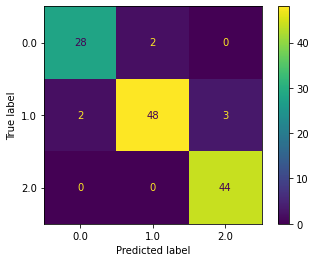

In [237]:
cm = confusion_matrix(targets.cpu(), predictions.cpu())
test_correct = 0
for i in range(3):
  test_correct += cm[i][i]
test_accuracy = test_correct/len(predictions)
print(f"Test Accuracy: {test_accuracy*100:>0.2f}%")
print(f"\nDone! Validation accuracy: {(100*best_accuracy):>0.2f}%")
print(f"Training took {(end_time-start_time).total_seconds():>0.2f} seconds")
cmd = ConfusionMatrixDisplay(cm, display_labels=encoder.classes_)
cmd.plot()

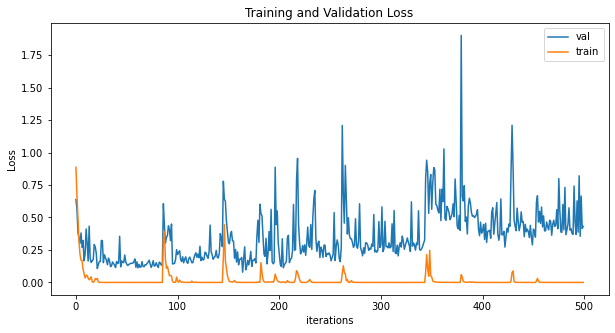

In [227]:
# Plot simple loss graph, see also tensorboard
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()